pr 1.03643053324e-05
k_init: 0.123
ose: 0.2969
z_aim: -100 with zflux of -1


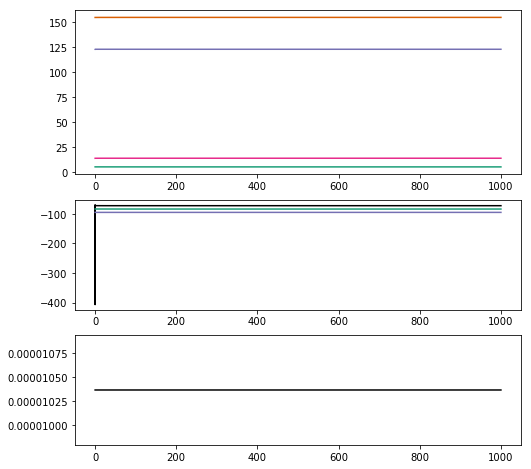

na 0.0138453987099 k 0.12302941927 cl 0.00516287955518 x 0.154962302465 vm -0.0725743429885 cle 0.119 ose 0.297 osi 0.297 deltx -8.32532244934e-26
w 1.96270598679e-12 radius 4.99899477602e-05
ecl -83.853135451 ek -95.1319279136 ena 62.7711665618 vm -72.5743429885


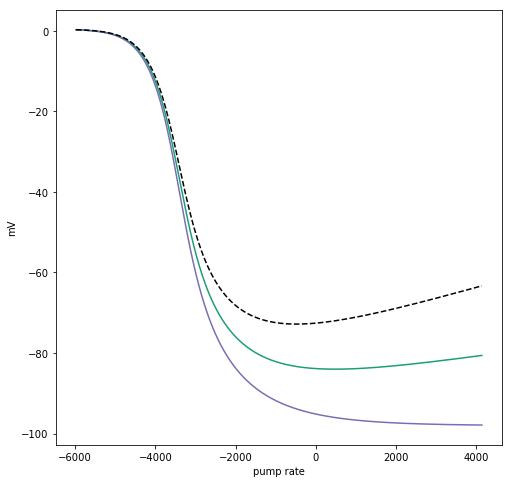

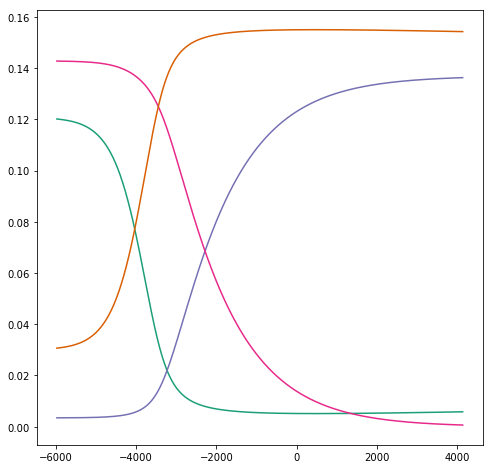

k_init: 0.123
ose: 0.2969
z_aim: -100 with zflux of -1


KeyboardInterrupt: 

In [2]:
# %load plm_singlecomp_withkcc2.py
"""
Created on Sun Aug 14 15:43:20 2016

@author: Kira

PLM model including KCC2

:::FUNCTIONS:::

plm(p,graph)
==> runs a time series plm run
p := desired pump rate
graph := {1 iff a graph is desired as output; and any other value otherwise}

zplm(z,gkcc,gcl)
==> runs the parametric solution over log pump rates in P for impermeant anion charge of z
z := charge of impermeant anions
gkcc := desired KCC2 conductance constant {default is 0}
gcl := desired Cl- conductance constant {default is 5e-8}

checkpara() 
==> checks the parametric solution over log pump rates in P against time series runs at points in P

zp(Z,p,gkcc) 
==> runs the parametric solution at the pump rate defined by p for different z values
Z := desired array of impermeant anion charges, multiplied by 100 (i.e. input as range(start*100, end*100))
p := initial log pump value satisfying the pump rate given by 10**(p)/(F*R) {default should be -5}
gkcc := kcc2 rate (NOT scaled i.e. add e-8 etc to it)

kcc2p(G,p,z)
==> runs the parametric solution at the pump rate defined by p for different gkcc2 values
G := desired array of gkcc2 (conductance through KCC2 co-transporter) values * 10**(10)
p := initial log pump value satisfying the pump rate given by 10**(p)/(F*R) {default should be -5}
z := charge of impermeant anions

kcc2para(G,z)
==> runs the parametric solution over log pump rates in P for different gkcc2s, for fixed impermeant anion charge of z
G := desired array of gkcc2 (conductance through KCC2 co-transporter) values [should be discrete here] * 10**(10)
z := charge of impermeant anions

gclp(G,p,z,gkcc2)
==> runs the parametric solution at the pump rate defined by p for different gcl values and a given gkcc2 conductance
G := desired array of gcl (chloride conductance) values * 10**(10)
p := initial log pump value satisfying the pump rate given by 10**(p)/(F*R) {default should be -5}
z := charge of impermeant anions
gkcc2 := desired KCC2 conductance constant

gclpara(G,z,gkcc2)
==> runs the parametric solution over log pump rates in P for different gcls, for fixed impermeant anion charge of z
G := desired array of gcl (chloride conductance) values * 10**(10)
z := charge of impermeant anions
gkcc2 := desired KCC2 conductance constant

deltax(X,z,p,gkcc)
==> runs the time series solution plm with a flux in impermeant anions allowed between 1000 and 3000 seconds
X := desired conductances of X (gx)
p := initial pump rate {default should be e-5/F}
z := charge of impermeant anions
gkcc := desired KCC2 conductance constant
"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from pylab import rcParams
rcParams['figure.figsize'] = 8,8
from plotting import clcolor, kcolor, xcolor, nacolor, wcolor, minithreefig

#constants
R=26.725*1e-3
F=96485.0 #R (RT/F) in Volts, where F is Faraday's constant in C/mol, and T is 37 deg C
n=200 #points to plot 
gna=2e-7
gk=7e-7
gcl=2e-7 #gna,gk,gcl: conductances in mS/cm^2 conv to S/dm^2 (10^-3/10^-2) - corrected for neuron
gkcc=2e-7 #1 is 'high' (Doyon) - use Chris's?
ck=2
cna=3 #cna,ck: pump (ATPase) stoichiometries
rad=5*1e-5 #radius in um convert to dm
rad0=rad
length=25*1e-5 #length in um converted to dm
nao=145e-3
clo=119e-3
ko=3.5e-3 #nao,clo,ko: extracellular concentrations (mM converted to M)
z=-0.85 #intracellular (and extracellular) charge of impermeant anions
gamma=gna/gk
beta=1.0/(gk*gcl+gkcc*gk+gcl*gkcc)
nae=nao
ke=ko
cle=clo
xe1=-1*(cle-nae-ke)
xe=xe1*0.2
ose=xe1+cle+nae+ke
P=range(-60000,-28750) 
#P=range(-30602,-30601) 
default_p=-0
default_P=-30601
vw=0.018 #partial molar volume of water, dm3/mol
pw=0.0015 #osmotic permeability, biological membrane (muscle? unknown), dm s
km=6*10**(-6) #extensional rigidity of RBC at 23 deg, Mohandas and Evans (1994), N/m

def plm(p=(10**(default_p))/(F),graph=0,pkcc=gkcc,gx=0,xt=100000,os_init=ose,clinit=5.2e-3,toff=150000,ton=150000,tt=200,xinit=154.9e-3,two=0,xe=xe,f4d=0,ke=ke,n=1800,k_init=123.0e-3,tk=100000,ratio=0.98,xend=120,osmofix=False,paratwo=False,moldelt=1e-13,xflux=0,z=z,dz=0,Zx=-1,ztarget=-100,length=length,areascale=1,rad=rad,title='fig.eps',neww=0):
    #create plotting arrays
    Vm=[]
    K=[]
    Na=[]
    Cl=[]
    W=[]
    X=[]
    time=[]
    Cl2=[]
    X2=[]
    Na2=[]
    K2=[]
    z_delt=[]
    xe_delt=[]
    gkcc_delt=[]
    J=[]
    
    dt=1e-3 #zero time, dt time step
    ts=tt/n #plotting timestep 
    ctr=1 #counter for plotting points
    t=0 #real time
    sw=1 #switch for ATPase action 
    
    w=np.pi*rad**2*length #initial volume in liters
    sa=2*np.pi*rad*(length)
    w1=w #initial volume stored for graphing later
    Ar=2.0/rad #area constant (F and H method)
    if areascale==0 or areascale==1:
        Ar=sa/w
    C=2e-4 #capacitance (F/dm^2)
    FinvCAr=F/(C*Ar) #(F/C*area scaling constant)
    sarest=sa
    
    na=13.8e-3
    x=xinit
    #cl=((os_init-na-k)*z+na+k)/(1+z)
    cl=clinit
    #x=(cl-na-k)/z #na,k,cl,x: intracellular starting concentrations
    k=k_init
        
    if osmofix==True:
        if xinit==0:
            x=(os_init-2*cl)/(1-z)
        else:
            cl=(os_init+(z-1)*x)/2.0
            print cl
    
    if k_init==0:
        k=cl-z*x-na
    print "k_init: "+str(k)
    print "ose: "+str(k+cl+x+na)
    print "z_aim: "+str(ztarget) +" with zflux of "+str(Zx)
    xm=x*ratio
    xtemp=x*(1-ratio)
    zxm=z
    zx=z
    cle=clo
    pdinit=-6.0
    pd=default_p
    em=(default_p-pdinit)/(12.0*10**4)
    
    if two==1:
        zx=Zx
        zxm=(z*x-zx*xtemp)/xm
        if paratwo==True:
            return (w*xinit)
        
    nathreshold=30e-3
    jpthreshold=p*(nathreshold/nao)**3
    jp=p*(na/nao)**3
        
    while t < tt: #loop over time              
        V=FinvCAr*(na+k-cl+z*x) #voltage
        
        #update arrays for plotting
        if t>=(ctr-1)*ts:
            K.append(1000*R*np.log(ke/k))
            K2.append(1000*k)
            Na.append(1000*R*np.log(nao/na))
            Na2.append(1000*na)
            Cl.append(1000*R*np.log(cl/cle))
            Cl2.append(cl*1000.0)
            X.append(z*1000*R*np.log(xe/x))
            X2.append(1000*(x))
            W.append(w)
            Vm.append(1000*V)
            time.append(t)
            z_delt.append(z)
            xe_delt.append(xe)
            gkcc_delt.append(pkcc)
            J.append(p)
            ctr+=1
        
        if tk+180>t>tk:
            pkcc += 1e-12    #control switch for gkkc ramp

        if dz!=0 and xt<t<xt+120 and xtemp>0 and xm>0:
            xtemp+=dz
            xm-=dz

        if two==1:
            z=(zxm*xm+zx*xtemp)/(xm+xtemp)
        
        if f4d!=0:
            if xt+120>t>xt:
                xe+=f4d*4e-4
                cle-=f4d*4e-4*1
        
        jp=p*(na/nao)**3 #cubic pump rate update (dependent on sodium gradient)
        
        if (toff>t) and (t>ton):
            if pd>pdinit:
                pd-=em/4
                p=(10**(pd))/F
            elif pd==pdinit:
                p=0
        elif t>toff:
            if pd<default_p:
                #sw+=(sw-2e-3)**(3)
                #sw+=sw/(2e-3+sw)*1e-5
                #sw+=np.exp(sw*20-20)
                #sw+=1.0/(12*10**4)
                pd+=em/4
                p=(10**(pd))/F
            
        #kcc2
        #jkcc2=50.0*pkcc*(ke*cle-k*cl) #Fraser and Huang
        jkcc2=pkcc*(K[ctr-2]-Cl[ctr-2])/1000.0 #Doyon

        #ionic flux equations
        dna=-dt*Ar*(gna*(V-R*np.log(nao/na))+cna*jp*sw) 
        dk=-dt*Ar*(gk*(V-R*np.log(ke/k))-ck*jp*sw-jkcc2)
        dcl=dt*Ar*(gcl*(V+R*np.log(cle/cl))+jkcc2) #dna,dk,dcl: increase in intracellular ion conc during time step dt
        dx=-dt*Ar*zx*(gx*(V-R/zx*np.log(xe/(xtemp))))
        na+=dna
        k+=dk
        cl+=dcl #increment concentrations
        
        if xend==0 and (t>xt):
            if (np.abs(x*w-xinit*w1)<moldelt) and (abs((np.abs(z)-np.abs(ztarget)))>0.001) and (min(z,zx)<=ztarget<=max(z,zx)):
                if xflux==0:
                    xtemp+=dx
                    tt=t+180
                else:
                    xtemp+=xflux
                    tt=t+180
            else:
                if (min(z,zx)<=ztarget<=max(z,zx)):
                    print 'anions stopped diffusing at '+str(t)
                    xend=1
                else:
                    if xflux!=0 and tt<1000 and xtemp>0 and (min(zxm,zx)<=ztarget<=max(zxm,zx)):
                        xtemp-=xflux
                        tt=t+50
                    else:
                        print 'anions stopped diffusing at '+str(t)
                        xend=1
                
        if xt+xend>t>xt:
            if xflux!=0:
                xtemp+=xflux
            else:
                xtemp+=dx 
            
        #update volume
        x=xm+xtemp
        osi=na+k+cl+x #intracellular osmolarity 
        ose=nae+ke+cle+xe+xe1*0.8
        w2=(w*osi)/ose #update volume
        w2=w+dt*(vw*pw*sa*(osi-ose))
        
        if neww==1:
            dt=1e-3
            w2=w+dt*(vw*pw*sa*(osi-ose)+1e-7*pw*km*(sarest-sa)/sarest)
            hyrdop=4*km*np.pi*(1-rad0/rad)
            w2=w+dt*(vw*pw*sa*(osi-ose-hydrop/(R*F))
        #length=w2/(np.pi*rad**2)
        
        #correct ionic concentrations by volume change
        na=(na*w)/w2
        k=(k*w)/w2
        cl=(cl*w)/w2
        x=(x*w)/w2
        xm=(xm*w)/w2
        xtemp=(xtemp*w)/w2
        w=w2
        if areascale==1:
            rad=np.sqrt(w/(np.pi*length))
            sa=2*np.pi*rad*(length)
            Ar=sa/w
            FinvCAr=F/(C*Ar)
        elif areascale==0:
            Ar=sa/w
            FinvCAr=F/(C*Ar)
            
        t+=dt
        
    #plot if asked    
    if graph==1:
        Vm[0]=-70
        gs = gridspec.GridSpec(3, 1, height_ratios=[1.5, 1, 1]) 
        plt.figure()
        plt.subplot(gs[0])
        plt.plot (time,Cl2,color=clcolor)
        plt.plot(time,K2,color=kcolor)
        plt.plot(time,X2,color=xcolor)
        plt.plot(time,Na2,color=nacolor)
        plt.subplot(gs[1])
        plt.plot(time,Vm,'k')
        plt.plot (time,Cl,color=clcolor)
        plt.plot(time,K,color=kcolor)
        plt.subplot(gs[2])
        plt.plot(time,J,color=wcolor,label='pump_rate')
        plt.savefig(title)
        plt.show()
    
    print 'na', na, 'k', k, 'cl', cl, 'x', x, 'vm', V, 'cle', cle, 'ose', ose, 'osi', osi, 'deltx', x*w-xinit*w1
    print 'w', w, 'radius', rad
    print 'ecl', Cl[-1], 'ek', K[-1], 'ena', Na[-1], 'vm', Vm[-1]
    return na, k, cl, x, V, Na[-1], K[-1], Cl[-1], X[-1], Vm[-1], W, time, Na, K, Cl, X, Vm, Cl2, Na2, K, X2, w, z_delt, xe_delt, gkcc_delt

def ecl(cli):
    return R*np.log(cli/clo)

def zplm(z=z,gkcc=gkcc,gcl=gcl,gna=gna,gk=gk,molinit=0):
    nai=[]
    ki=[]
    cli=[]
    xi=[]
    vm=[]
    zi=[]
    pi=[]
    ena=[]
    ek=[]
    ecl=[]
    exi=[]
    ev=[]
    w=[]
    #beta=1.0/(gk*gcl-gkcc*gcl+gk*gkcc)
    for p in P:
        q=10**(p/10000.0)/(F*R)
        if z==-1:
            theta=0.5*ose/(nae*np.exp(-3*q/gna)+ke*np.exp(2*q*(gcl+gkcc)*beta))
        else:
            theta=(-z*ose+np.sqrt(z**2*ose**2+4*(1-z**2)*cle*np.exp(-2*q*gkcc*beta)*(nae*np.exp(-3*q/gna)+ke*np.exp(2*q*(gcl+gkcc)*beta))))/(2*(1-z)*((nae*np.exp(-3*q/gna)+ke*np.exp(2*q*(gcl+gkcc)*beta))))    
        v=(-np.log(theta))*R
        vm.append(v)
        zi.append(nae*np.exp(-v/R-3*q/gna))
        nai.append(nae*np.exp(-v/R-3*q/gna))
        ki.append(ke*np.exp(-v/R+2*q*(gcl+gkcc)*beta))
        cli.append(cle*np.exp(+v/R-2*q*gkcc*beta))
        xi.append(ose-nai[-1]-cli[-1]-ki[-1])
        pi.append(1000.0*np.log10(F*R*q/(((nae*np.exp(-v/R-3*q/gna))/nae)**3)))
        
        ek.append(1000*R*np.log(ke/ki[-1]))
        ena.append(1000*R*np.log(nae/nai[-1]))
        ecl.append(1000*R*np.log(cli[-1]/cle))
        exi.append(z*1000*R*np.log(xe/xi[-1]))
        ev.append(1000.0*v)
        if molinit != 0:
            w.append((molinit)/xi[-1])
        else:
            w.append(0.1549/xi[-1])
    
    plt.figure()
    plt.plot(pi,ecl,color=clcolor)
    plt.plot(pi,ek,color=kcolor)
    #plt.plot(pi,ena,color=nacolor)
    #plt.plot(pi,xi,color=xcolor)
    plt.plot(pi,ev,'k--')
    plt.ylabel('mV')
    plt.xlabel('pump rate')
    plt.savefig('pump_mV.eps')
    plt.show()
    
    return pi, ena, ek, ecl, exi, ev, nai, ki, cli, xi, vm, w

"""a=plm(neww=1,ton=10,toff=90,tt=200)
delta=[a[11][1:-1],a[14][1:-1],a[13][1:-1],a[16][1:-1],a[10][1:-1],a[20][1:-1]]
b=plm(neww=0,ton=10,toff=90,tt=200)
delta2=[b[11][1:-1],b[14][1:-1],b[13][1:-1],b[16][1:-1],b[10][1:-1],b[20][1:-1]]

plt.figure()
gs = gridspec.GridSpec(3,1,height_ratios=[1.5,0.5,0.5])
ax0=plt.subplot(gs[0])
ax0.plot(delta[0],delta[1],color=clcolor)
ax0.plot(delta[0],delta[2],color=kcolor)
ax0.plot(delta[0],delta[3],'k')
ax0.plot(delta2[0],delta2[3],color='k',linestyle=':')
ax0.plot(delta2[0],delta2[1],color=clcolor,linestyle=':')
ax0.plot(delta2[0],delta2[2],color=kcolor,linestyle=':')
#ax0.set_ylim([-95,-75])
ax1=plt.subplot(gs[1])
ax1.plot(delta[0],delta[4],color=wcolor) #volume
ax1.plot(delta2[0],delta2[4],color=wcolor,linestyle=':')
#ax1.set_ylim([1.01e-13,1.04e-13])
ax2=plt.subplot(gs[2])
ax2.plot(delta[0],delta[5],color=xcolor) #conc X
ax2.plot(delta2[0],delta2[5],color=xcolor,linestyle=':')
#ax2.set_ylim([0,2.1e-7])
plt.savefig('volcon.eps')
plt.show()"""

print 'pr',10**(default_p)/(F)

a=plm(graph=1,tt=1000)

para=zplm()
plt.figure()
plt.plot(para[0],para[8],color=clcolor,linestyle='-')
plt.plot(para[0],para[7],color=kcolor,linestyle='-')
plt.plot(para[0],para[6],color=nacolor,linestyle='-')
plt.plot(para[0],para[9],color=xcolor,linestyle='-')
plt.show()

offpump=plm(graph=1,ton=500,toff=1500,tt=2500,title='f1c_neo.eps')

k_init: 0.123029
ose: 0.296999
z_aim: -100 with zflux of -1


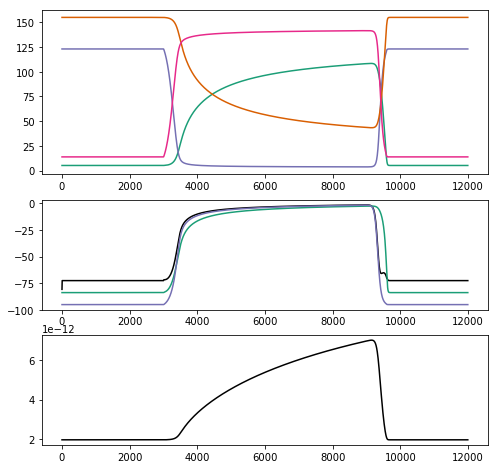

na 0.0138453987138 k 0.123029419914 cl 0.00516287952995 x 0.154962301842 vm -0.0725743431097 cle 0.119 ose 0.297 osi 0.297 deltx -9.75915603067e-26
w 1.96349158392e-12 radius 4.9999951304e-05


In [1]:
import figure_1
#figure_1.f1b()
#figure_1.f1c()
#figure_1.f1d()

k_init: 0.123029
ose: 0.296999
z_aim: -100 with zflux of -1
k_init: 0.123029
ose: 0.296999
z_aim: -100 with zflux of -1
k_init: 0.123029
ose: 0.296999
z_aim: -100 with zflux of -1
k_init: 0.123029
ose: 0.296999
z_aim: -100 with zflux of -1
k_init: 0.123029
ose: 0.296999
z_aim: -100 with zflux of -1
k_init: 0.123029
ose: 0.296999
z_aim: -100 with zflux of -1
k_init: 0.123029
ose: 0.296999
z_aim: -100 with zflux of -1
k_init: 0.123029
ose: 0.296999
z_aim: -100 with zflux of -1
k_init: 0.123029
ose: 0.296999
z_aim: -100 with zflux of -1
k_init: 0.123029
ose: 0.296999
z_aim: -100 with zflux of -1
k_init: 0.123029
ose: 0.296999
z_aim: -100 with zflux of -1
k_init: 0.123029
ose: 0.296999
z_aim: -100 with zflux of -1
k_init: 0.123029
ose: 0.296999
z_aim: -100 with zflux of -1
k_init: 0.123029
ose: 0.296999
z_aim: -100 with zflux of -1
k_init: 0.123029
ose: 0.296999
z_aim: -100 with zflux of -1
k_init: 0.123029
ose: 0.296999
z_aim: -100 with zflux of -1
k_init: 0.123029
ose: 0.296999
z_aim: -1

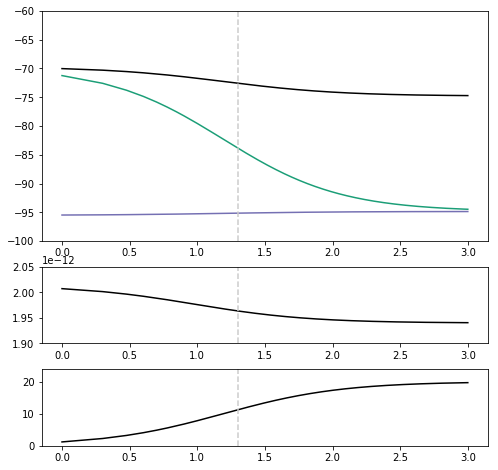

In [1]:
import figure_2or3
#figure_2or3.f2a()
#figure_2or3.f3a()
figure_2or3.f3b()
#figure_2or3.f3d()
#figure_2or3.f3d()

k_init: 0.123029
osi: 0.296999
z_aim: -100 with zflux of -1
na 0.0138454023951 k 0.123030086494 cl 0.00516281685846 x 0.154961716397 vm -0.072574502077 cle 0.119 ose 0.297 osi 0.29700002215 deltx 1.76542056974e-13
w 3.10276140226e-12 radius 6.28534686015e-05 z -0.85
ecl -83.8534600056
11.2789579286
11.2787924635
2
k_init: 0.123029
osi: 0.296999
z_aim: -100 with zflux of -1
na 0.0141255099697 k 0.180975996376 cl 0.00360272359083 x 0.225300600281 vm -0.0814916157624 cle 0.119 ose 0.297 osi 0.424004830217 deltx 1.41977599881e-13
w 1.98066394327e-12 radius 5.02181208071e-05 z -0.85
ecl -93.4689070987
11.9772913363
11.2787889321
540001


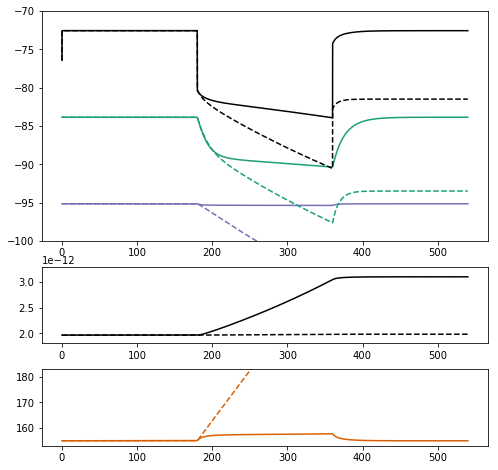

In [1]:
import fig4, fig5
#fig4.f4a()
#fig4.f4b()
#fig4.f4c()
#fig4.f4d()
#fig5.f5a()
#fig5.f5b()
#fig5.f5c()
#fig5.f5d()
fig4.neww(neww=2)
#fig5.new5()

0.00516015
k_init: 0.123029
osi: 0.29699615
z_aim: -100 with zflux of -1
na 0.0138174564444 k 0.118475106504 cl 0.00534769211154 x 0.14935974494 vm -0.0717025580343 cle 0.119 ose 0.297 osi 0.287 deltx -2.17219825559e-13
w 5.82803284561e-13 radius 2.72405614609e-05 z -0.85
ecl -82.9132009082
0.00516015
k_init: 0.123029
osi: 0.29699615
z_aim: -100 with zflux of -1
na 0.0138245511859 k 0.119613670183 cl 0.00530021462462 x 0.150761564006 vm -0.071923607895 cle 0.119 ose 0.297 osi 0.2895 deltx -1.83139309936e-13
w 8.03439963985e-13 radius 3.19839261812e-05 z -0.85
ecl -83.1515283614
0.00516015
k_init: 0.123029
osi: 0.29699615
z_aim: -100 with zflux of -1
na 0.0138315720776 k 0.120752227201 cl 0.00525360302492 x 0.152162597696 vm -0.072142559503 cle 0.119 ose 0.297 osi 0.292 deltx -1.37725688765e-13
w 1.09449686879e-12 radius 3.7330372285e-05 z -0.85
ecl -83.3875951844
0.00516015
k_init: 0.123029
osi: 0.29699615
z_aim: -100 with zflux of -1
na 0.0138385207419 k 0.121890803808 cl 0.0052078325

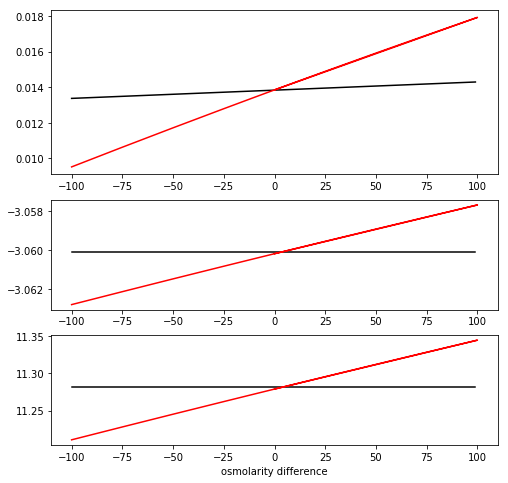

In [3]:
from plm_singlecomp_withkcc2 import gkcc, gcl, gk, gna, ose, cle, nae, ke, xe, gkcc, F, R, default_P, z, beta, plm, default_p
from plotting import clcolor, kcolor, nacolor, xcolor
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from fig4 import f4e

def f5d(os=range(-100,100)):
    gs = gridspec.GridSpec(3, 1, height_ratios=[1.5, 1, 1]) 
    plt.figure()
    a1=plt.subplot(gs[0])
    a2=plt.subplot(gs[1])
    a3=plt.subplot(gs[2])
    
    nai=[]
    ki=[]
    cli=[]
    xi=[]
    oi=[]
    ena=[]
    ek=[]
    ecl=[]
    exi=[]
    ev=[]
    pi=[]
    os2=[]
    os3=[]
    
    q=10**(default_P/10000.0)/(F*R)
    
    for o in os:
        theta=(-z*(ose+o/10000.0)+np.sqrt(z**2*(ose+o/10000.0)**2+4*(1-z**2)*cle*np.exp(-2*q*gkcc*beta)*(nae*np.exp(-3*q/gna)+ke*np.exp(2*q*(gcl+gkcc)*beta))))/(2*(1-z)*((nae*np.exp(-3*q/gna)+ke*np.exp(2*q*(gcl+gkcc)*beta))))
        v=(-np.log(theta))*R
        nai.append(nae*np.exp(-v/R-3*q/gna))
        ki.append(ke*np.exp(-v/R+2*q*(gcl+gkcc)*beta))
        cli.append(cle*np.exp(+v/R-2*q*gkcc*beta))
        xi.append(ose-nai[-1]-cli[-1]-ki[-1]+o/1000.0)
        pi.append(default_P/10000.0)
        
        ek.append(1000*R*np.log(ke/ki[-1]))
        ena.append(1000*R*np.log(nae/nai[-1]))
        ecl.append(1000*R*np.log(cli[-1]/cle))
        exi.append(z*1000*R*np.log(xe/xi[-1]))
        ev.append(1000.0*v)
    
    #a1.plot(os,ecl,color=clcolor)
    #a1.plot(os,ek,color=kcolor)
    #plt.plot(os,ena,color=nacolor)
    #plt.plot(os,exi,color=xcolor)
    #a1.plot(os,ev,'k--')
    a1.plot(os,nai,color='k')
    
    #a2.plot(os,cli,color=clcolor)
    #a2.plot(os,ki,color=kcolor)
    #a2.plot(os,nai,color=nacolor)
    #a2.plot(os,xi,color=xcolor)
    a2.plot(os,pi,color='k')
    
    a3.plot(os,np.array(ev)-np.array(ecl),color='k')
    #a3.plot(os,pi)
    #plt.show()
    
    plt.xlabel('osmolarity difference')
    
    on=[-0.1,-0.075,-0.05,-0.025,-0.01,0,0.01,0.025,0.05,0.075,0.1]
    p_plm_osmo=[]
    
    for a,i in enumerate(os,0):
        for b in on:
            if a==b*1000:
                p_plm_osmo.append(pi[i])
    
    #for l,o in enumerate(p_plm_osmo,0):
        #d=plm(neww=0,os_choose=o,os_init=ose+o,osmofix=True,tt=1000,xinit=0,areascale=1)
    for m in (2,7):
        if m==1:
            shape='*'
        elif m==2:
            shape='s'
        elif m==3:
            shape='o'
        for l,o in enumerate(on,0):
            d=plm(neww=m,osmofix=True,os_choose=o/10.0,tt=1000,areascale=1,xflux=o*1e-5,xt=180,xend=180,graph=0)
            oh=(d[-2]-d[-1])*10000
            os2.append(d[-3])
            os3.append(oh)
            #a1.plot(oh,d[21],'k'+shape)
            #a2.plot(oh,d[17][-1]/1000,'g'+shape)
            #a2.plot(oh,d[18][-1]/1000,'m'+shape)  
            #a2.plot(oh,d[19][-1]/1000,'b'+shape)
            #a2.plot(oh,d[20][-1]/1000,'r'+shape)
            #a3.plot(oh,d[16][-1]-d[14][-1],'k'+shape)
    
    nai=[]
    ki=[]
    cli=[]
    xi=[]
    oi=[]
    ena=[]
    ek=[]
    ecl=[]
    exi=[]
    ev=[]
    pi=[]
    
    for x,o in enumerate(os3,0):
        q=10**(os2[x])/(F*R)
        theta=(-z*(ose+o/1000.0)+np.sqrt(z**2*(ose+o/1000.0)**2+4*(1-z**2)*cle*np.exp(-2*q*gkcc*beta)*(nae*np.exp(-3*q/gna)+ke*np.exp(2*q*(gcl+gkcc)*beta))))/(2*(1-z)*((nae*np.exp(-3*q/gna)+ke*np.exp(2*q*(gcl+gkcc)*beta))))
        v=(-np.log(theta))*R
        nai.append(nae*np.exp(-v/R-3*q/gna))
        ki.append(ke*np.exp(-v/R+2*q*(gcl+gkcc)*beta))
        cli.append(cle*np.exp(+v/R-2*q*gkcc*beta))
        xi.append(ose-nai[-1]-cli[-1]-ki[-1]+o/1000.0)
        pi.append(np.log10(F*R*q/(((np.exp(-v/R-3*q/gna)))**3)))
        
        ek.append(1000*R*np.log(ke/ki[-1]))
        ena.append(1000*R*np.log(nae/nai[-1]))
        ecl.append(1000*R*np.log(cli[-1]/cle))
        exi.append(z*1000*R*np.log(xe/xi[-1]))
        ev.append(1000.0*v)
    
    #a1.plot(os3,ecl,color=clcolor)
    #a1.plot(os3,ek,color=kcolor)
    #a1.plot(os3,ev,'k--')
    a1.plot(os3,nai,color='r')
    
    #a2.plot(os3,cli,color=clcolor)
    #a2.plot(os3,ki,color=kcolor)
    #a2.plot(os3,nai,color=nacolor)
    #a2.plot(os3,xi,color=xcolor)
    a2.plot(os3,os2,color='r')
    
    a3.plot(os3,np.array(ev)-np.array(ecl),color='r')
    #a3.plot(os,pi)
    #plt.show()
    
    plt.savefig('f6d.eps')
    plt.show()
    return oi, ena, ek, ecl, exi, ev, nai, ki, cli, xi

def f5b(moldelt=0):
    XF=[-1.20,-1.15,-1.1,-1.05,-1.0,-0.95,-0.9,-0.85,-0.8,-0.75,-0.7,-0.65,-0.6,-0.55,-0.501]
    XFp=[]
    cl=[]
    vm=[]
    k=[]
    w=[]
    Z=[]
    x=[]
    df=[]
    newpr=[]
    nai=[]
    ki=[]
    cli=[]
    xi=[]
    vm=[]
    pi=[]
    ena=[]
    ek=[]
    ecl=[]
    exi=[]
    ev=[]
    df2=[]
    nai2=[]
    pi, zi, zee, newx = f4e(moldelt=moldelt)
    
    for i in range(len(zi)):
        for b in XF:
            if zi[i]/100.0==b:
                #XFp.append(pi[i])
                XFp.append(default_p)
    
    for a in range(len(XFp)):
        #dez=plm(two=1,xt=10,dz=3e-6,Zx=a,tt=5000)
        dez=plm(z=XF[a],tt=1000,p=(10**(XFp[a]))/F,graph=0,osmofix=True,xinit=0)
        newpr.append(dez[-3])
        cl.append(dez[7])
        k.append(dez[6])
        vm.append(dez[9])
        w.append(dez[10][-1])
        Z.append(dez[22][-1]*100)
        x.append(dez[3])
        df.append(dez[9]-dez[7])
    
    pi=[]
    pi1=[]
    pi2=[]
    df3=[]
    
    for m,o in enumerate(newpr,0):
        q=10**(default_P/10000.0)/(F*R)
        pi1.append(default_P/10000.0)
        z=XF[m]
        theta=(-z*(ose)+np.sqrt(z**2*(ose)**2+4*(1-z**2)*cle*np.exp(-2*q*gkcc*beta)*(nae*np.exp(-3*q/gna)+ke*np.exp(2*q*(gcl+gkcc)*beta))))/(2*(1-z)*((nae*np.exp(-3*q/gna)+ke*np.exp(2*q*(gcl+gkcc)*beta))))
        v=(-np.log(theta))*R
        nai2.append(nae*np.exp(-v/R-3*q/gna))
        pi2.append(np.log10(F*R*q/(((np.exp(-v/R-3*q/gna)))**3)))
        df3.append(1000.0*v-1000*R*np.log(cle*np.exp(+v/R-2*q*gkcc*beta)/cle))

    for m,o in enumerate(newpr,0):
        q=10**(o)/(F*R)
        z=XF[m]
        theta=(-z*(ose)+np.sqrt(z**2*(ose)**2+4*(1-z**2)*cle*np.exp(-2*q*gkcc*beta)*(nae*np.exp(-3*q/gna)+ke*np.exp(2*q*(gcl+gkcc)*beta))))/(2*(1-z)*((nae*np.exp(-3*q/gna)+ke*np.exp(2*q*(gcl+gkcc)*beta))))
        v=(-np.log(theta))*R
        nai.append(nae*np.exp(-v/R-3*q/gna))
        ki.append(ke*np.exp(-v/R+2*q*(gcl+gkcc)*beta))
        cli.append(cle*np.exp(+v/R-2*q*gkcc*beta))
        xi.append(ose-nai[-1]-cli[-1]-ki[-1])
        pi.append(np.log10(F*R*q/(((np.exp(-v/R-3*q/gna)))**3)))
        
        ek.append(1000*R*np.log(ke/ki[-1]))
        ena.append(1000*R*np.log(nae/nai[-1]))
        ecl.append(1000*R*np.log(cli[-1]/cle))
        exi.append(z*1000*R*np.log(xe/xi[-1]))
        ev.append(1000.0*v)
        df2.append(ev[-1]-ecl[-1])
    plt.figure()
    gs = gridspec.GridSpec(3,1,height_ratios=[1.5,0.5,0.5])
    Z=XF[0:14]
    a0=plt.subplot(gs[0])
    #a0.plot(Z,ecl,color=clcolor)
    #a0.plot(Z,cl,'bo')
    #a0.plot(Z,k,'go')
    #a0.plot(Z,vm,'ko')
    #a0.plot(Z,ek,color=kcolor)
    a0.plot(Z,nai,'k')
    a0.plot(Z,nai2,'r')
    #a0.set_ylim([-110,-60])
    #a1=plt.subplot(gs[1])
    #a1.plot(zi,zee[11],color='k') #vol
    #a1.plot(z,w,'ko')
    #a1.set_ylim([0,5e-12])
    a2=plt.subplot(gs[1])
    a2.plot(Z,newpr,color='k') #conc X
    a2.plot(Z,pi1,'r')
    #a2.plot(Z,x,'mo')
    #a2.set_ylim([0.11,0.2])
    a3=plt.subplot(gs[2])
    #a3.plot(Z,df,'ko')
    a3.plot(Z,df2,'k')
    a3.plot(Z,df3,'r')
    #a3.set_ylim([0,21])
    plt.savefig('f6b.eps')
    plt.show()
    return

a = f5d()

k_init: 0.123029
osi: 0.296999
z_aim: -100 with zflux of -1


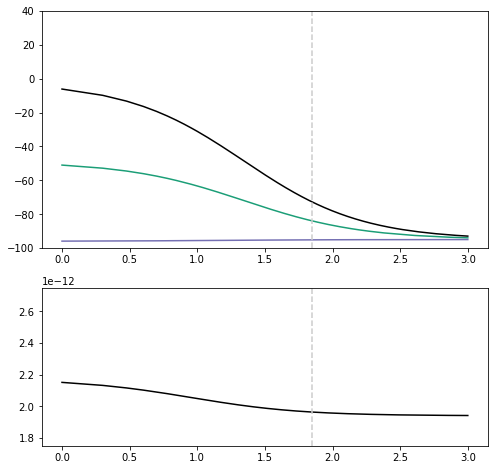

k_init: 0.123029
osi: 0.296999
z_aim: -100 with zflux of -1


figure_2or3.py:113: RuntimeWarning: overflow encountered in double_scalars
  pi=np.log10(F*R*q/(((nae*np.exp(-v/R-3*q/gna))/nae)**3))
figure_2or3.py:113: RuntimeWarning: divide by zero encountered in double_scalars
  pi=np.log10(F*R*q/(((nae*np.exp(-v/R-3*q/gna))/nae)**3))


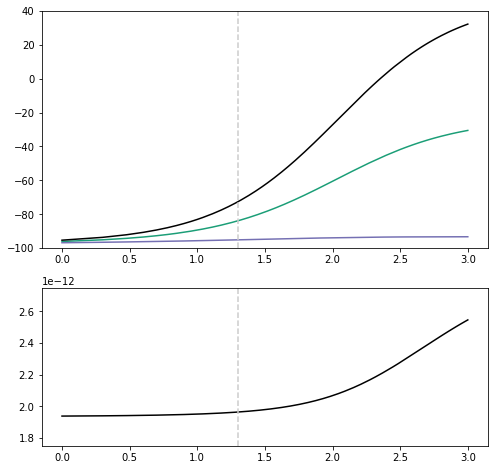

In [2]:
import figure_2or3
figure_2or3.f2()

k_init: 0.123029
osi: 0.296999
z_aim: -1 with zflux of -1
na 0.0138669503498 k 0.126673506862 cl 0.00502426333307 x 0.151435279582 vm -0.0732489284539 cle 0.119 ose 0.297 osi 0.297000000128 deltx -3.44120059519e-25
w 2.00922252945e-12 radius 5.05788649405e-05 z -0.894918265665
ecl -84.5804732793
11.3315448254
11.2787924632
k_init: 0.123029
osi: 0.296999
z_aim: -1 with zflux of -1
na 0.0142466471084 k 0.126294180982 cl 0.00502829685822 x 0.151430873723 vm -0.0732862121971 cle 0.119 ose 0.297 osi 0.296999998671 deltx -2.89997890534e-25
w 2.00928098749e-12 radius 5.05796007275e-05 z -0.894920135863
ecl -84.5590268081
11.272814611


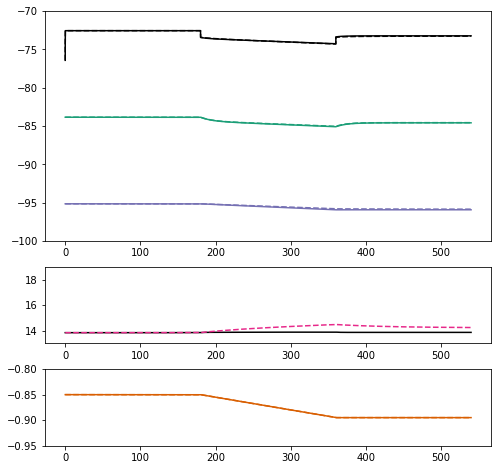

In [1]:
import fig5, fig4, figure_2or3
#figure_2or3.f3d(new=1,title='f6f.eps')
fig5.f5a(new=1,title='f6a.eps')
#fig4.f4c()
#fig4.f4c(new=1,title='f6c.eps',tt=900,xt=180)